\tableofcontents

\newpage

Para comenzar, vamos a hacer los imports y a declarar funciones que nos ayuden a dibujar las imágenes de forma más sencilla durante el resto de la práctica. La mayoría son tomadas de la práctica inicial, aunque algunas han sufrido ciertas modificaciones. Algunas consideraciones:

- Declaramos la función *BRG2RGB* pues estamos usando *matplotlib* para dibujar las imágenes, y recordamos que OpenCV utiliza BRG como forma de representar los colores, y matplotlib utilica RGB.

- Podremos dibujar las imágenes de varias formas: una única imagen con *pintaI*, varias imágenes de distintos tamaños reescalandolas con *pintaMI*, varias imágenes de distintos tamaños sin reescalar con *pintaMIReduced*


In [135]:

import cv2
import numpy as np
from matplotlib import pyplot as plt

def BRG2RGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def readIMG(filename,flagColor = 1):
        if flagColor == 0:
            return cv2.imread(filename,flagColor).astype(np.float64)
        else:
            return BRG2RGB(cv2.imread(filename,flagColor)).astype(np.float64)
    
#Found on: https://note.nkmk.me/en/python-opencv-hconcat-vconcat-np-tile/. Concats readjusting size
def hconcat_resize_min(im_list, interpolation=cv2.INTER_CUBIC):
    h_min = min(im.shape[0] for im in im_list)
    im_list_resize = [cv2.resize(im, (int(im.shape[1] * h_min / im.shape[0]), h_min), interpolation=interpolation)
                      for im in im_list]
    return cv2.hconcat(im_list_resize)

def normalizeM(m):
    if len(m.shape) == 3 and m.shape[2] == 3:  # tribanda
        for i in range(3):
            imax, imin = m[:,:,i].max(), m[:,:,i].min()
            if imax == imin:
                m[:,:,i] = 0
            else:
                m[:,:,i] = ((m[:,:,i] - imin)/(imax - imin)) 
    elif len(m.shape) == 2:    # monobanda
        imax, imin = m.max(), m.min()
        if imax == imin:
            m = 0
        else:
            m = ((m - imin)/(imax - imin))
    # escalamos la matriz
    m *= 255
    return m


def pintaI(im,title = "img"):
    
    # Normalize [0,255] as integer
    img = np.copy(normalizeM(im))
    img = np.copy(im)
    if len(img.shape) == 2:
        img = cv2.cvtColor(img.astype(np.uint8),cv2.COLOR_GRAY2BGR).astype(np.float64)
        img = img.astype(np.uint8)
        img = BRG2RGB(img)
    else :
        img = img.astype(np.uint8)
   
    
    plt.title(title)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    cv2.waitKey(0)

def pintaMI(vim,title = "imgs"):

    vim = [normalizeM(i) for i in vim]
    #Pasa a "formato color" las imágenes que estén en blanco y negro
    for i,im in enumerate(vim):
        if len(im.shape) == 2:
            vim[i] = cv2.cvtColor(vim[i].astype(np.uint8),cv2.COLOR_GRAY2BGR).astype(np.float64)
    
    #Use found function to resize
    images = hconcat_resize_min(vim)
    pintaI(images,title)

def pintaMIReduced(vim,title = "imgs"):
    
    copy = np.copy(vim)
    copy = [normalizeM(i) for i in copy]
    wmax = max(im.shape[1] for im in copy[1:len(copy)-1])
    for i,im in enumerate(copy):
        if len(im.shape) == 2:
            copy[i] = cv2.cvtColor(copy[i].astype(np.uint8),cv2.COLOR_GRAY2BGR).astype(np.float64)
        if im.shape[1] < wmax:
            copy[i] = cv2.copyMakeBorder(copy[i], 0,0,0,wmax - im.shape[1],borderType= cv2.BORDER_CONSTANT)
    
    im = cv2.vconcat(copy[1:len(copy)-1])
    if im.shape[0] > copy[0].shape[0]:
        copy[0] = cv2.copyMakeBorder(copy[0],0,im.shape[0]- copy[0].shape[0],0,0,borderType = cv2.BORDER_CONSTANT)
    else:
        im      = cv2.copyMakeBorder(im,0,copy[0].shape[0]-im.shape[0],0,0,borderType = cv2.BORDER_CONSTANT)
    images = cv2.hconcat([copy[0],im])
    pintaI(images,title)

def pintaMITitles(vim,titles):
    title = " - ".join(titles)
    pintaMI(vim,title)
    

Vamos a  leer un conjunto de imágenes de imágenes y a dibujar su estado original antes de comenzar 

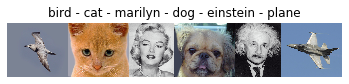

In [136]:
bird = normalizeM(readIMG('imagenes/bird.jpg'))
cat  = normalizeM(readIMG('imagenes/cat.jpg'))
mari = normalizeM(readIMG('imagenes/marilyn.jpg',0))
dog = normalizeM(readIMG('imagenes/dog.jpg',1))
einst = normalizeM(readIMG('imagenes/einstein.jpg',0))
plane = normalizeM(readIMG('imagenes/plane.jpg',1))

bwdog = readIMG('imagenes/dog.jpg',0)
bwcat = readIMG('imagenes/cat.jpg',0)
bwplane = readIMG('imagenes/plane.jpg',0)
bwbird  = readIMG('imagenes/bird.jpg',0)




pintaMITitles([bird,cat,mari,dog,einst,plane],
              ["bird","cat","marilyn","dog","einstein","plane"])

# Convolución 2D

Vamos a aplicar una Gaussiana 2D a una imagen. Implementaremos por ello el código de una convolución 2D en general, pero hecha como la composición de 2 convoluciones 1D. . Nuestra función **convolution2D** tomará como parámetros:

- La imagen (o matriz)
- Los kérnels para el eje (kx,ky), que serán vectores que le pasaremos a la función *filter2D*
- El tipo de borde que queremos utilizar, pues cuando se aplique la convolución en los píxeles de los extremos necesitaremos simular píxeles de fuera de la imagen. Por ello, podremos especificar diferentes tipos de bordes , como pueden ser *BORDER_CONSTANT*, que añade un número fijo (usualmente cero) en los píxeles extras, o *BORDER_REPLICATE* que replica el último pixel tantas veces como sea necesario

Dentro de la función de convolución, haremos la convolución con la función *filter2D*. Esta función, en realidad, hace una correlación. Así que , para hacer una convolución, tenemos que darle la vuelta a los vectores que se nos den, para lo cual usamos la función **flip** de *numpy*. Entonces, aplicaremos primero la convolución por filas, para lo cual traspondremos el vector *kx*, pues viene dado como vector columna. La función devuelve la matriz a la que se le han realizado las respectivas convoluciones.

Más abajo, se encuentra la función objetivo del primer apartado de la práctica. La función **gaussian2D**, realiza un alisado gaussiano. Los parámetros que toma son los siguientes:

- Una imagen (o matriz)
- Un sigma, pues sabemos que cuando queremos aplicar una gaussiana sobre una imagen , el kernel que se aplica para la convolución en filas y para columnas es el mismo pero traspuesto
- Un tamaño del kérnel o máscara. Si no le pasamos ninguno o indicamos cero,, lo calcularemos por la sabida relación:

$$
ksize = 2*3*sigma +1
$$

- Un tipo de borde, que será el que luego se envíe como parámetro a la función *convolution2D*

Tras estos parámetros, en la función se obtendrá el kernel haciendo uso de la función de OpenCV *getGaussianKernel* que, dado un tamaño de kernel y un sigma, nos devuelve el vector de kernel para ese sigma dado. Utilizamos luego el kernel obtenido para enviarlo a la función *convolution2D* dos veces, una como *kx* y otra como *ky*, pues como hemos dicho antes, en las gaussianas, son el mismo.

A continuación, el código y un par de ejemplos ejecutados:

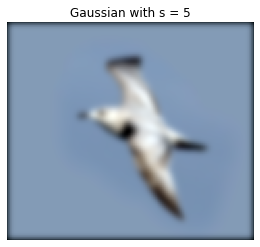

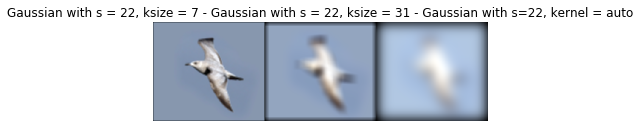

In [137]:


def convolution2D(img,kx,ky,border):
    """ 
    Convolves img with 2 kernels(one in each axis). Uses different kinds of borders
    """
    # flip kernels and transpose kx
    kx,ky = np.flip(kx).T, np.flip(ky)

    #Apply rows convolution and then, columns convolution
    blurredR = cv2.filter2D(img,-1,kx,  borderType = border)
    blurredC = cv2.filter2D(blurredR,-1,ky, borderType = border)
    return blurredC

def gaussian2D(img,sigma,ksize = 0,border = cv2.BORDER_CONSTANT):
    """ 
    Applies a gaussian filter to a img
    ksize is the dimension
    If kernel size = 0, we calculate it by ksize = 2*3*sigma + 1
    """
    if ksize == 0 :
        ksize = int(6*sigma + 1)
    
    kernel = cv2.getGaussianKernel(ksize,sigma)
    return convolution2D(img,kernel,kernel,border)

    
a = gaussian2D(bird,5,border = cv2.BORDER_CONSTANT)
b = gaussian2D(bird,22,7,border = cv2.BORDER_ISOLATED)
c = gaussian2D(bird,22,31,border = cv2.BORDER_ISOLATED)
d = gaussian2D(bird,22,border = cv2.BORDER_ISOLATED)
pintaI(a,"Gaussian with s = 5")
pintaMITitles([b,c,d], ["Gaussian with s = 22, ksize = 7", "Gaussian with s = 22, ksize = 31","Gaussian with s=22, kernel = auto"])




Apreciamos que si damos al kernel un tamaño que no sea $(0,0)$, al aplicar el filtro gaussiano con valores de sigma bajos, el resultado es diferente que si el tamaño es $(0,0)$, esto es debido a que si el tamaño es $(0,0)$, estamos indicando que en realidad este se calculará en función del sigma. La imagen final cuando el tamaño del kernel no se calcula automáticamente según los sigmas queda menos difuminada que si el tamaño es $(0,0)$. En las imágenes de abajo, podemos observar que si el tamaño del kernel aumenta, la imagen adquiere un difuminado mucho mayor y hace notar en los bordes el tipo de borde que se ha indicado: *BORDER_ISOLATED*, que indica que no se mire más allá de la imagen. Además, se aprecia tambien bastante bien que si con un sigma alto, ponemos un tamaño de kernel pequeño, la imagen queda bastante poco difuminada, esto es lógico pues con el sigma que hemos puesto, el tamaño del kérnel según lo que sabemos debería ser $ksize = 2*3*22 +1$, que es bastante mayor que $7$. 

## Derivadas de una imagen

Se pide a continuación mostrar qué ocurre en la imagen al aplicar máscaras 1D sobre una imagen. Para obtener estas máscaras, utilizaremos la función de OpenCV *getDerivKernels* que , dados dos enteros que serán los órdenes de las correspondientes derivadas que queramos calcular en cada uno de los ejes $x$ e $y$, nos devolverá dos kernels que podremos aplicar a la imagen para ver cómo son sus derivadas. Además, podremos pasarle también opcionalmente si queremos normalizar las máscaras o no, y un tamaño de kernel específico. Una vez que se obtienen las máscaras, utilizamos la función *convolution2D* anterior para aplicar la convolución del kernel con nuestra imagen.

Mostramos ahora el código de nuestra función *maskDerivKernels*, que calculará las derivadas y aplicará la convolución. Luego, mostramos un par de ejemplos.


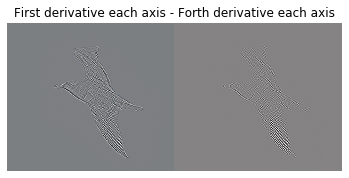

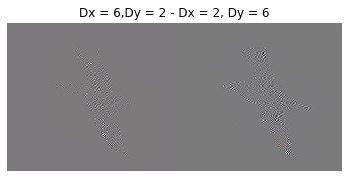

In [138]:
def maskDerivKernels(img,dx = 1,dy = 1,ksize = 3,border = cv2.BORDER_REPLICATE):
    """
    getDerivKernels returns coefficients to get images partial derivatives.
    dx and dy are respectively the partial orders for x and y.
    """
    dxdy = cv2.getDerivKernels(dx,dy,ksize,normalize = 0)
    return convolution2D(img,dxdy[0],dxdy[1],border)

imgDeriv1 = maskDerivKernels(bird)
imgDeriv2 = maskDerivKernels(bird,3,3,9)
imgDeriv3 = maskDerivKernels(bird,6,2,9)
imgDeriv4 = maskDerivKernels(bird,2,6,9)

pintaMITitles([imgDeriv1,imgDeriv2],["First derivative each axis","Forth derivative each axis"])
pintaMITitles([imgDeriv3,imgDeriv4],["Dx = 6,Dy = 2", "Dx = 2, Dy = 6"])

Al aplicar derivadas sobre una imagen, lo que estamos tratando de hallar es los cambios de tonalidades que se dan en la imagen. Podemos ver que a medida que aumentamos las derivadas en uno de los ejes, nuestro método trata de encontrar los cambios de tonalidad que hay en nuestra imagen de forma más fuerte. Así, como podemos ver en las dos últimas imágnes, si aumentamos la derivada en el eje X, los cambios de tonalidad seran de la imagen escogida serán menores en ese eje, y si aumentamos la derivada en el eje Y , se obtiene algo más de información sobre la imagen.


# Laplaciana de gaussiana

Vamos a implementar una función que utilice la función anterior para calcular la convolución 2D de una máscara Laplaciana aplicada a una imagen a la que previamente se le ha pasado un filtro gaussiano. Para ello, estableceremos la profundidad deseada al valor $-1$, que lo iguala al de la imagen original. 
Recordamos que el operador laplaciano en general para una función $f$ en el espacio $n-dimensional$ euclídeo viene dado por 

$$
\Delta f = \sum_{i = 1}^n \frac{\partial^2 f}{\partial x^2_i}
$$

Lo podemos implementar por tanto, usando la función anterior dos veces, una le pasamos como derivadas $dx = 2$, $dy = 0$, y en la segunda lo hacemos al revés. Sumamos los resultados y obtenemos el laplaciano de la imagen. Esto lo hace la función *laplacian* que hemos implementado.


Queremos ahora implementar una función que nos de una laplaciana de gaussiana, es decir, queremos obtener una imagen a la que primero se le ha aplicado un filtro gaussiano para alisarla y a continuación se le aplica un filtro laplaciano para tratar de encontrar los cambios de tonalidad en ella. El resultado, como veremos más adelante, será una obtención clara de los contornos de las figuras de la imagen.
A continuación, definimos la función *laplacian_gaussian*, que hará la tarea que queremos realizar. Para ello, tomará como parámetros (además de la imagen):

- Un sigma que será el que utilicemos para el alisado gaussiano
- Un tamaño para el kernel gaussiano, lo llamaremos kGaussian
- Un tamaño para el kernel laplaciano, kLaplacian
- Un borde opcional, al igual que en las anteriores, que se usará en la convolución

Se muestra a continuación el código de las funciones descritas y algunos ejemplos 

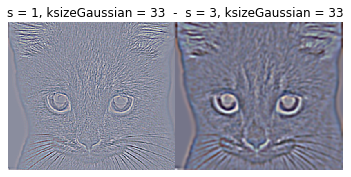

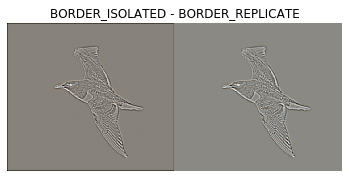

In [139]:
def laplacian(img,ksize):
    d2x   = maskDerivKernels(img,2,0,ksize)
    d2y   = maskDerivKernels(img,0,2,ksize)
    return d2x + d2y
    
def laplacian_gaussian(img,sigma1,kGaussian,kLaplacian,border = cv2.BORDER_DEFAULT):
    gauss = gaussian2D(img,sigma1,kGaussian,border)
    lap = laplacian(gauss,kLaplacian)
    return lap


lapgau1 = laplacian_gaussian(cat,1,33,5)
lapgau2 = laplacian_gaussian(cat,3,33,5)

lapgau3 = laplacian_gaussian(bird,1,99,3,cv2.BORDER_ISOLATED)
lapgau4 = laplacian_gaussian(bird,1,99,3,cv2.BORDER_REPLICATE)


pintaMI([lapgau1,lapgau2], "s = 1, ksizeGaussian = 33  -  s = 3, ksizeGaussian = 33")
pintaMI([lapgau3,lapgau4], "BORDER_ISOLATED - BORDER_REPLICATE")

 Con esto, lo que conseguimos es primero alisar la imagen de manera que los cambios de color queden menos bruscos y luego, mediante el operador laplaciano con las segundas derivadas, obtener dónde están los cambios más fuertes en estos colores, obteniendo así los contornos en la figura.  Se puede observar en las imágenes del gato, que si el $\sigma$ es mayor (en este caso se ha usado $\sigma = 3$) el suavizado lo es y el interior de nuestra imagen queda algo más difuminado, no se aprecian tan bien dentro cada cambio de tonalidad.
 
 En la imagen de abajo, se ha utilizado en ambas un tamaño grande de kérnel, y se aprecia como con el mismo $\sigma$, cambiando solamente el tipo de borde, cambia un poco la tonalidad de la foto por el suavizado gaussiano.

# Pirámides

A continuación, vamos a definir un par de funciones que nos ayudarán para los siguientes ejemplos. Definiremos:

- La función *subsample*, en la que nos quedaremos con las filas y columnas pares de la imagen para reducir su tamaño. La otra
- La función *upsample*, que irá añadiendo en las posiciones pares filas y columnas que sean copias de la fila o columna que ocupe la siguiente posición. Al terminar de añadir, se hará un *gaussianBlur* con sigma bajo y tamaño de kernel bajo, y usando reflejo en el borde, para realizar un pequeño alisado en la imagen y suavizar los píxeles con los que se han introducido


In [140]:
def subsample(img):
    return img[::2, ::2]

def upsample(img):
    i = [2*a for a in range(0,img.shape[0])]
    j = [2*a for a in range(0,img.shape[1])]
    for a in i:
        img = np.insert(img,a+1,img[a,:],axis = 0)
        
    for a in j:
        img = np.insert(img,a+1,img[:,a],axis = 1)
    
    img = gaussian2D(img,1,3,cv2.BORDER_REFLECT)
        
    return img


Tras haber reducido, podremos dibujar un conjunto de imágenes con diferentes tamaños juntas (sin perder la relación entre sus tamaños) con la función *pintaMIReduced* que declaramos al principio.

## Pirámide gaussiana

Ahora, vamos a generar una pirámide gaussiana de 4 niveles. Lo que haremos en cada iteración es aplicar un filtro gaussiano para suavizar los cambios de tonalidad, y luego utilizar la función *subsample* anterior para reducir el tamaño de la imagen. A partir de esta pirámide, podremos reconstruir la información más importante de la imagen, como veremos más adelante con la pirámide laplaciana, sin guardar la imagen completa. Haremos la función en el caso general de $n$ niveles. Para ello, necesitaremos como parámetros:

- La imagen original
- El número de niveles que queremos hacer de pirámide
- El tamaño del kernel
- El sigma que queremos aplicar en cada iteración de la pirámide
- El borde que se quiere aplicar en el alisado gaussiano

**Nota.-** El bucle en el código va hasta el rango $iters+1$ pues queremos devolver un vector que tenga la imagen original junto con $iters$ imágenes más.

Dibujamos después algunos ejemplos con diferentes tipos de bordes
    

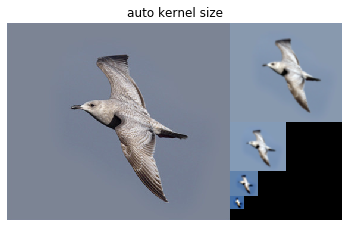

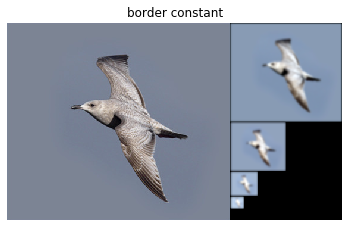

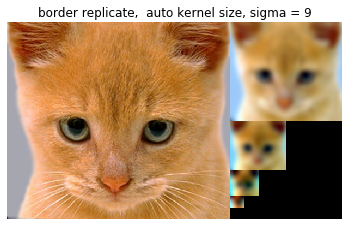

In [141]:
def gaussianPyramid(orig,iters,ksize,sigma1,border = cv2.BORDER_DEFAULT):
    pyramid = [orig]
    
    for i in range (0,iters+1):
        blurred = gaussian2D(pyramid[i],sigma1,ksize,border)
        subsampled = subsample(blurred)
        pyramid.append(subsampled)

    return pyramid

pyramid = gaussianPyramid(bird,4,0,2)
pyramid2 = gaussianPyramid(bird,4,0,3,cv2.BORDER_CONSTANT)
pyramid3 = gaussianPyramid(cat,4,0,9,cv2.BORDER_REPLICATE)


pintaMIReduced(pyramid,"auto kernel size")
pintaMIReduced(pyramid2, "border constant")
pintaMIReduced(pyramid3, "border replicate,  auto kernel size, sigma = 9")



Podemos apreciar como al poner que el border sea de tipo *BORDER_CONSTANT*, creamos una pequeña marca negra entre las imágenes mostradas de la pirámide gaussiana, que es justamente el borde remarcado de estas. *BORDER_REPLICATE* no produce un gran efecto en nuestro alisado, por lo que no apreciamos a simple vista el efecto que tiene sobre los bordes la pirámide gaussiana. Hay que observar que las imágenes van perdiendo toda la capacidad, los colores pierden intensidad y los detalles cambian un poco en su importancia. Esto es lógico al realizar el suavizado sobre la imagen sucesivas veces. Vemos también que si tomamos un sigma *relativamente alto*, como $\sigma = 9$ en la última, la velocidad con la que se produce el difuminado es muy alta y pronto la imagen queda casi indistinguible.

## Pirámide Laplaciana

Vamos a construir ahora la pirámide laplaciana.Lo primero que haremos es darle la vuelta al vector de de la pirámide Gaussiana, pues queremos empezar con la última imagen. Ahora, para construir la pirámide laplaciana, esta se construye haciendo sucesivamente:

- Upsample del $nivel_i$ de la pirámide gaussiana, utilizando la función que hemos declarado anteriormente
- $$nivel_i = upsample - nivelGaussiano_{i+1}$$, y añadimos este nivel a la pirámide laplaciana

Como consideraciones, debemos saber que tras hacer el upsample, hemos podido generar una imagen que sea de una dimensión mayor tanto en filas como en columnas (o en una sola de ambas) que la imagen original de la pirámide gaussiana. Esto es debido a que al hacer el subsample, si una de las dimensiones tenía dimensión impar , al dividirla por la mitad tomamos el redondeado hacia arriba de la división para establecer la dimensión. Por tanto, hemos creado la función *rmRowCol*, que se define encima de *laplacianPyramid*, y que dadas las dos imágenes, comprueba que las dimensiones de la imagen a la que se le ha hecho un *upsample*, y elimina una fila o columna o ambas de esta, según corresponda.

Tras esto, definimos la función ya mencionada *laplacianPyramid*, a la que se le pasa como argumento una pirámide gaussiana,y  devolverá una pirámide laplaciana con las imágenes puestas de más grandes en las primeras posiciones y más chicas en las últimas , esto es para dibujarlos de manera más sencilla con las funciones que ya teníamos. Se realizan después de las declaraciones de las funciones un par de ejemplos ilustrativos

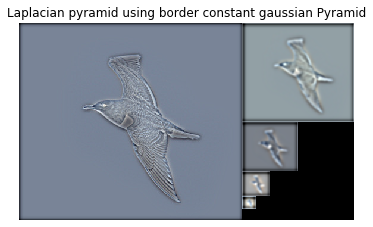

In [142]:
def rmRowCol(up, img):
    # Check rows
    if up.shape[0] > img.shape[0]:
        up = up[:up.shape[0]-1,::]
    #Check cols
    if up.shape[1] > img.shape[1]:
        up = up[::,:up.shape[1]-1]
    return up

def laplacianPyramid(gaussPyramid):
    gaussPyramid = gaussPyramid[::-1]
    pyramid = [gaussPyramid[0]]
    levels = len(gaussPyramid)-1
    for i in range(0,levels):
        up = upsample(gaussPyramid[i])
        #Check if they have the same dimensions
        if up.shape != gaussPyramid[i+1].shape:
            up = rmRowCol(up,gaussPyramid[i+1])
        #Create level of Laplacian Pyramid
        level = np.subtract(up,gaussPyramid[i+1])
        pyramid.append(level)
    
    return pyramid[::-1]

lap_pyramid = laplacianPyramid(pyramid)
lap_pyramid_borderC = laplacianPyramid(pyramid2)
pintaMIReduced(lap_pyramid_borderC, "Laplacian pyramid using border constant gaussian Pyramid")

En ambos casos, la imagen inicial es la más pequeña del lado derecho. Podemos observar como a partir de una imagen de muy poco tamaño y muy difuminada, podemos obtener perfectamente los contornos bien marcados de la imagen original. Como hemos mencionado, esto puede servirnos para guardar mucha menos información de la imagen y aún así poder reconocer sin problema atributos de la misma.

Podemos observar tambien que en el segundo ejemplo, a pesar de que los bordes estaban marcados en los primeros niveles, pues hemos cogido la pirámide 2 de las gaussianas, la que tiene el borde constante. Además, como la imagen original tenía  color, vemos como el tono que adquiere el fondo es un gris azulado. Los bordes que aparecen en los demás niveles de la pirámide laplaciana van desapareciendo gradualmente, al ir haciendo la diferencia entre las imágenes.

## Espacio de escalas laplaciano

Vamos a utilizar el algoritmo descrito en el guión de prácticas para construir un espacio de escalas laplaciano. Vamos a definir primero un par de funciones que nos servirán más adelante para probar lo que hemos hecho. Estas serán:

- *drawCircles*, que pintarán círculos en las regiones que encontremos tras construir el espacio de escalas laplaciano. Necesitaremos pasarle la imagen, un $\sigma$ que nos servirá para que los círculos sean de tamaño proporcional $k*\sigma$ al tamaño de este, donde $k$ también lo pasaremos como parámetro. Por último, la función recibirá también la escala que queremos para detectar las regiones.

- *supressNoMax*, que realizará la supresión de no máximos de la imagen que se obtenga como parámetro. Como nota, irá copiando los valores en una nueva matriz para no modificar los valores en la original y que pudieran surgir problemas con los máximos locales debido a esto.

In [143]:

#cv.Circle(img, center, radius, color, thickness=1, lineType=8, shift=0) → None
def drawCircles(image,sigma,k,scale):
    index = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] > scale:
                index.append((j,i))

    for i in index:
        image = np.copy(cv2.circle(image,i,int(k*sigma),255,thickness = 1))
        
    return image

def supressNoMax(img):
    ret = np.copy(img)
    m = np.copy(img)
    m = np.insert(m,0,0,axis = 0)
    m = np.insert(m,m.shape[0],0,axis = 0)
    m = np.insert(m,0,0,axis = 1)
    m = np.insert(m,m.shape[1],0,axis = 1)

    for x in range(1,m.shape[0]-1):
        for y in range(1,m.shape[1]-1):
            n = np.copy(m[x-1:x+2,y-1:y+2])
            n[1][1] = 0
            vmax = np.max(n)
            if vmax >= m[x][y]:
                ret[x-1][y-1] = 0
            else:
                ret[x-1][y-1] = m[x][y]  
    return ret




Una vez que tenemos estas dos funciones, el **espacio de escalas laplaciano** se construye realizando el siguiente algoritmo:

- Inicializamos $\sigma = 1$. Al final de cada iteración, lo iremos aumentando multiplicándolo 
- Se calcula la laplaciana de gaussiana normalizada en escala. Tenemos una función (*laplacian_gaussian*) que nos calcula esta laplaciana de gaussiana. Para normalizarla, multiplicamos por $\sigma^2$.
- Luego, guardamos el cuadrado de esta matriz, pues queremos que todos los valores sean positivos. Con esto habremos obtenido una escala, la guardaremos en un vector de escalas

Una vez que hemos obtenido el espacio de escalas laplaciano, aprovecharemos la misma función para que cada vez que se calcule una escala, se le haga una supresión de no máximos y se introduzca en otro vector, que se devolverá junto al vector de escalas. Definimos con estas indicaciones la función *laplacianScaleSpace*, que recibirá como argumento una imagen, un número de iteraciones y una constante de proporcionalidad por la que aumentaremos el $\sigma$ inicial

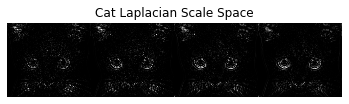

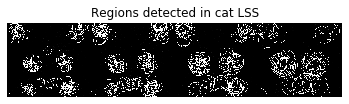

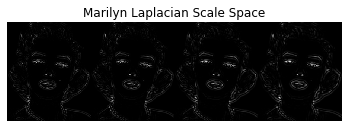

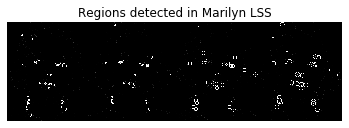

In [144]:
def laplacianScaleSpace(img,n,k):
    sigma = 1
    scales = []
    nomax  = []
    
    for i in range(0,n):
        #Calculate Laplacian of gaussian and normalize in scale
        lgn = laplacian_gaussian(img,sigma,9,9)*sigma*sigma
        #Save the m^2
        squared = np.power(lgn,2)
        scales.append(squared)
        #update sigma
        sigma = sigma*k
        #first supressNoMax, then normalize
        supressed = normalizeM(supressNoMax(squared))
        nomax.append(supressed)
    
    return scales,nomax


s,n   = laplacianScaleSpace(mari,4,1.2)
for i,im in enumerate(n):
    n[i] = drawCircles(im,np.power(1.3,i),3,100)

bwcat = readIMG('imagenes/cat.jpg',0)
s1,n1 = laplacianScaleSpace(bwcat,4,1.3)
for i,im in enumerate(n1):
    n1[i] = drawCircles(im,np.power(1.3,i),20,100)
pintaMI(s1, "Cat Laplacian Scale Space")
pintaMI(n1, "Regions detected in cat LSS")
pintaMI(s, "Marilyn Laplacian Scale Space")
pintaMI(n, "Regions detected in Marilyn LSS")



Para ambas imágenes hemos usado 4 niveles. En la imagen del *gato*, hemos usado un incremento de $\sigma$ de 1.2. Podemos apreciar en el espacio de escalas laplaciano como van apareciendo cada vez menos puntos en la imagen (de izquierda a derecha), pues el alisado va siendo mayor, y al calcular las segundas derivadas detecta menos cambios en las tonalidades, como era de esperar. Tratamos de buscar las regiones que queden por encima de $100$. Vemos que al aumentar el alisado, vemos que la cantidad de regiones que se detectan en esta imagen va disminuyendo su concentración y van dispersándose los las regiones localizadas. Además, parece que se pierden ciertas regiones pues el número de puntos en ciertas zonas (como las de las orejas en este caso) son menores. 

En la imagen de Marilyn, se ha utilizado un incremento del sigma de $1.3$. No se detecta mucho cambio entre las imágnees del espacio de escalas laplaciano. Esto podría deberse a que como la imagen es en blanco y negro, al seguir suavizando las altas frecuencias de la imagen, los cambios no se detecten mucho pues siguen siendo contornos de la cara. Sin embargo, si tratamos de localizar las regiones cuya tonalidad quede de nuevo por encima de 100,tenemos un efecto parecido al caso anterior, al ir suavizando la imagen las regiones se van dispersando y se van perdiendo algunas de ellas.

# Imágenes híbridas

Vamos a tratar de hacer imágenes híbridas, guiados por el paper *SIGGRAPH* de 2006. Dadas dos imágenes, si queremos hacer una híbrida entre ellas, tenemos que tratar de obtener las altas frecuencias de una y las bajas de otra y juntarlas. Para ello:

- Realizamos un alisamiento gaussiano (y normalizaremos el resultado) para reducir las altas frecuencias de la imagen y quedarnos más con las bajas
- Realizamos una diferencia entre la segunda imagen original y la aplicacion de un filtro gaussiano a esa misma imagen para quedarnos con las altas frecuencias
- Devolvemos una imagen que sea la suma de ambas imágenes

Como nota, debemos aclarar que los sigmas que se usan para los alisamientos de cada imagen son diferentes. Implementamos ahora la función en varias líneas e incluimos código para mostrar los ejemplos pedidos.

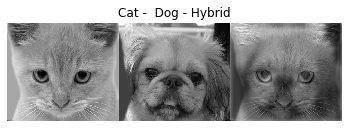

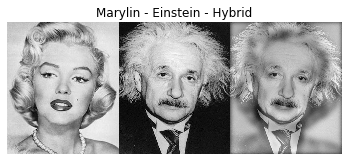

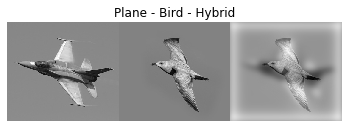

In [145]:
def hybridImage(img1,img2,s1,s2):
    high = normalizeM(gaussian2D(img1,s1))
    low  = img2 - normalizeM(gaussian2D(img2,s2))
    return high + low

hybrid1 = hybridImage(bwdog,bwcat,8,8)
scaleH1 = gaussianPyramid(hybrid1,4,9,1)

hybrid2 = hybridImage(mari,einst,5,10)
scaleH2 = gaussianPyramid(hybrid2,4,9,1)

hybrid3 = hybridImage(bwplane,bwbird,10,24)
scaleH3 = gaussianPyramid(hybrid3,4,9,1)

pintaMI([bwcat,bwdog,hybrid1], "Cat -  Dog - Hybrid")
pintaMI([mari,einst,hybrid2], "Marylin - Einstein - Hybrid")
pintaMI([bwplane,bwbird,hybrid3], "Plane - Bird - Hybrid")



Ahora, pintamos las pirámides gaussianas para ver qué ocurre

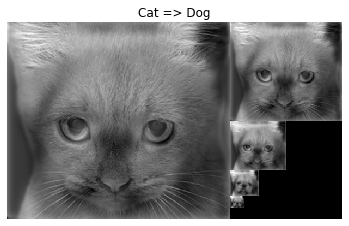

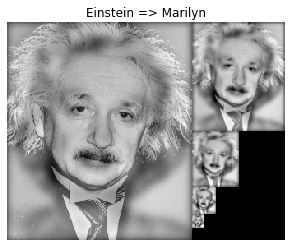

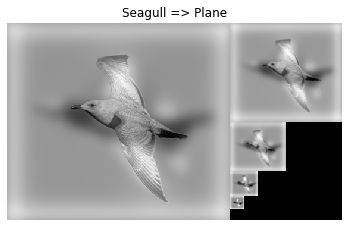

In [146]:
# Pyramids
pintaMIReduced(scaleH1,"Cat => Dog")
pintaMIReduced(scaleH2,"Einstein => Marilyn")
pintaMIReduced(scaleH3,"Seagull => Plane")

Para todas las parejas, la pirámide gaussiana se ha realizado con $\sigma = 4$ y $ksize = 9$.

Podemos observar que el efecto que se produce es el de un **alejamiento del observador** respecto de la imagen. Así, si por ejemplo en la última estamos viendo al principio una gaviota, en las últimas imágenes nos encontramos que estamos viendo un avión

# Bonus 2

Vamos ahora a hacer las imágenes híbridas pero en color. Como antes hicimos una en blanco y negro, ahora tomaremos otra de las parejas que será:

- Motocicleta - Bicicleta

Para todas las parejas, la pirámide gaussiana se ha realizado con $\sigma = 4$ y $ksize = 9$.

Hay que comentar que , en la pareja *moto-bici*, se ha escogido el mismo $\sigma = 5$ para ambas imágenes al hibridarlas. En la pareja *perro-gato*, se ha tomado un sigma más alto para la imagen del gato (concretamente $\sigma = 5$ para el perro y $\sigma = 10$ para el gato), y en la última pareja, hemos tomado $\sigma =10$ para el avión y $\sigma = 24$ para la gaviota. Estos últimos sigmas son más altos pues de otro modo no se resaltaban bien las características de la gaviota y no era intuitivo crear la imagen híbrida.

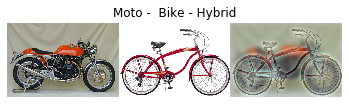

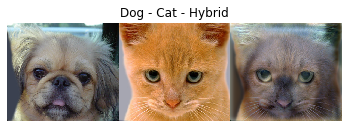

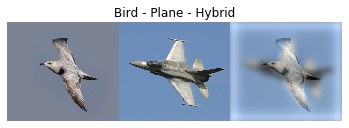

In [147]:
moto = readIMG('imagenes/motorcycle.jpg')
bici = readIMG('imagenes/bicycle.jpg')

hybrid1 = hybridImage(moto,bici,8,8)
scaleH1 = gaussianPyramid(hybrid1,4,9,1)

hybrid2 = hybridImage(dog,cat,5,10)
scaleH2 = gaussianPyramid(hybrid2,4,9,1)

hybrid3 = hybridImage(plane,bird,10,24)
scaleH3 = gaussianPyramid(hybrid3,4,9,1)

pintaMI([moto,bici,hybrid1], "Moto -  Bike - Hybrid")
pintaMI([dog,cat,hybrid2], "Dog - Cat - Hybrid")
pintaMI([bird,plane,hybrid3], "Bird - Plane - Hybrid")

Y, dibujamos las pirámides para apreciar el cambio según la *distancia*

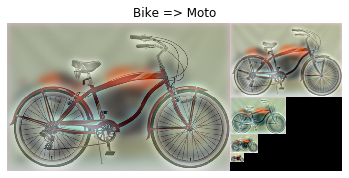

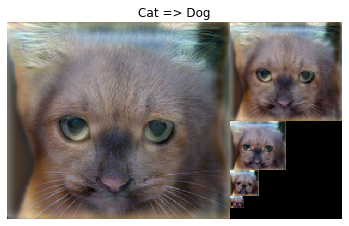

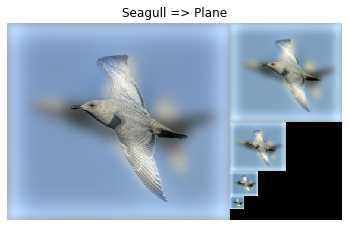

In [148]:
# Pyramids
pintaMIReduced(scaleH1,"Bike => Moto")
pintaMIReduced(scaleH2,"Cat => Dog")
pintaMIReduced(scaleH3,"Seagull => Plane")

# Bonus 3

Por último, vamos a coger dos imágenes de internet y vamos a tratar de hacer una hibridación de estas. Para ello, hemos tomado dos imágenes de dos objetos que tienen la misma forma pero no son el mismo aunque tengan la misma forma: un cubo de rubik y una caja. Mostramos primero las fotos

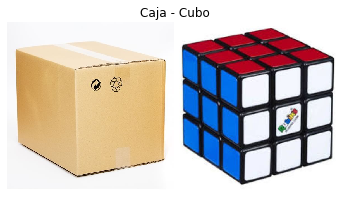

In [149]:
caja = readIMG('imagenes/caja.jpg', 1)
cubo = readIMG('imagenes/rubik.jpg',1)
pintaMI([caja,cubo],"Caja - Cubo")

Ahora, vamos a tratar de hibridar estas fotos, mostrarlas las 3 juntas y luego realizar una pirámide gaussiana para tratar de hacer un *efecto de alejamiento* sobre las imágenes

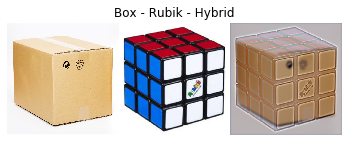

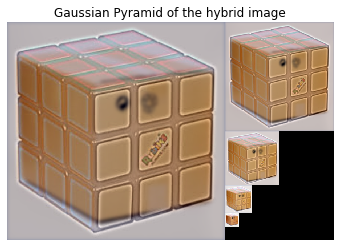

In [150]:

h = hybridImage(caja,cubo,5,5)
pintaMI([caja,cubo,h],"Box - Rubik - Hybrid")
scaleBonus = gaussianPyramid(h,4,9,1)
pintaMIReduced(scaleBonus, "Gaussian Pyramid of the hybrid image")

En la pirámide gaussiana se aprecia como estamos viendo de primeras un cubo de rubik con sus colores, que conforme avanzamos en las imágenes se van difuminando y queda una caja marrón en la última imagen. Hay que comentar que hemos tenido que ajustar el sigma para la caja como un sigma muy bajo para que el alisado fuera pequeño, pues se pierde mucho el color de esta si tomamos un sigma más grande y casi no se aprecia el cambio entre las imágenes. El sigma del cubo lo hemos tomado suficientemente grande para que no se pierdan del todo los colores y pueda verse por encima de la caja.